#Импорт библиотек

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os # библиотеки работы с папками и системой

# и другие уже известные нам библиотеки
import pandas as pd
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

#Функция для оценки на приватном лидерборде (все данные)

In [ ]:
# Функция для оценки на приватном лидерборде (все данные)
def calc_f1_score(test_url: str, prediction_url: str) -> float:

    true_labels = pd.read_csv(test_url)
    pred_labels = pd.read_csv(prediction_url)
    # Таргет для месячного прогноза
    true_labels_month = true_labels['target_month'].values
    pred_labels_month = pred_labels['target_month'].values

    # Таргет для 10 дневного прогноза
    true_labels_day = true_labels['target_day'].values
    pred_labels_day = pred_labels['target_day'].values

    # Посчитаем метрику для месяца и 10 дней
    score_month = f1_score(true_labels_month, pred_labels_month)
    score_day = f1_score(true_labels_day, pred_labels_day)
    # Посчитаем метрику с весом для двух таргетов
    score = 0.5 * score_month + 0.5 * score_day
    return score, score_month, score_day


#Загрузка данных

In [ ]:
!unrar x /content/drive/MyDrive/DataWagon/train_2.rar /content/drive/MyDrive/DataWagon/train_2/


UNRAR 6.11 beta 1 freeware      Copyright (c) 1993-2022 Alexander Roshal


Extracting from /content/drive/MyDrive/DataWagon/train_2.rar


Would you like to replace the existing file /content/drive/MyDrive/DataWagon/train_2/test/dislok_wagons.parquet
11392957 bytes, modified on 2023-11-08 12:28
with a new one
11392957 bytes, modified on 2023-11-08 12:28

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit q

Program aborted


In [ ]:
!cp -r /content/train/content/имя_папки /content/drive/MyDrive/DataWagon

cp: cannot stat '/content/train/content/имя_папки': No such file or directory


In [ ]:
!ls /content/drive/MyDrive/DataWagon/train

dislok_wagons.parquet  metrics_f1.py	stations.parquet	tr_rems.parquet
freight_info.parquet   prediction	target			wagons_probeg_ownersip.parquet
kti_izm.parquet        pr_rems.parquet	task2_base_model.ipynb	wag_params.parquet


In [ ]:
path = '/content/drive/MyDrive/DataWagon/train'

In [ ]:
# список вагонов с остаточным пробегом на момент прогноза
wag_prob = pd.read_parquet(path + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# данные по дислокации
dislok = pd.read_parquet(path + '/dislok_wagons.parquet').convert_dtypes()
# параметры вагона
wag_param = pd.read_parquet(path + '/wag_params.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem = pd.read_parquet(path + '/pr_rems.parquet').convert_dtypes()
# текущие ремонты вагонов
tr_rem = pd.read_parquet(path + '/tr_rems.parquet').convert_dtypes()
# данные по КТИ
kti_izm = pd.read_parquet(path + '/kti_izm.parquet').convert_dtypes()
# справочник грузов
freight_info = pd.read_parquet(path + '/freight_info.parquet').convert_dtypes()
# справочник станций
stations = pd.read_parquet(path + '/stations.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
target = pd.read_csv('/content/drive/MyDrive/DataWagon/train_2/test/target/y_test.csv').convert_dtypes()

In [ ]:
wag_prob

,repdate,wagnum,ost_prob,manage_type,rod_id,reestr_state,ownership_type,month
0,2022-08-01,33361,7541,0,1,1,0,8
1,2022-08-02,33361,7243,0,1,1,0,8
2,2022-08-03,33361,6990,0,1,1,0,8
3,2022-08-04,33361,6347,0,1,1,0,8
4,2022-08-05,33361,6027,0,1,1,0,8
...,...,...,...,...,...,...,...,...
9249584,2022-12-20,33350,35062,0,1,0,0,12
9249585,2022-12-21,33350,35062,0,1,0,0,12
9249586,2022-12-22,33350,35062,0,1,0,0,12
9249587,2022-12-23,33350,35062,0,1,0,0,12


**Таблица wag_prob. Список вагонов, по которым известен пробег и тип владения на дату среза:**

Дата среза, Номер вагона, Остаточны пробег, Вид упраления по договору (1-собственноые, 2-лизинговые, 11-сервисные), Тип РПС, Состояние в реестре (1-слеженение, 3-вкдючение, 4-готовится к искл.), Тип собственности (1-собственные, 2-принятые в аренду, 4-привелеченный парк, 6-сервис), Месяц

In [ ]:
dislok

,plan_date,wagnum,date_kap,date_dep,kod_vrab,date_pl_rem,id_road_disl,st_id_dest,id_road_dest,st_id_send,id_road_send,ost_prob,isload,fr_id,last_fr_id,distance
0,2022-08-01,1071,NaT,2020-02-16,0,2023-02-16,42,22,42,11470,42,36899,0,5032,1413,-1
1,2022-08-02,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36899,1,1204,1204,998
2,2022-08-03,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,989
3,2022-08-04,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,939
4,2022-08-05,1071,NaT,2020-02-16,0,2023-02-16,42,11663,0,11470,42,36711,1,1204,1204,963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1052920,2023-01-27,9554,2009-10-13,2021-08-23,1,2024-08-23,37,22,37,12647,37,87693,0,5032,3253,-1
1052921,2023-01-28,9554,2009-10-13,2021-08-23,1,2024-08-23,37,22,37,12647,37,87693,0,5032,3253,-1
1052922,2023-01-29,9554,2009-10-13,2021-08-23,1,2024-08-23,37,22,37,12647,37,87693,0,5032,3253,-1
1052923,2023-01-30,9554,2009-10-13,2021-08-23,1,2024-08-23,37,22,37,12647,37,87693,0,5032,3253,-1


**Таблица dislok. Информация по дислокации:**

Дата отчета, Номер вагона, Дата последнего капитального ремонта, Дата последнего деповского ремонта, Код предстоящего планового ремонта, Дата предстоящего планового ремонта, Код дороги дислокации, Ид. станции назначения, Код дороги назначения, Индекс станции отправления, Код дороги отправления, Остаточный пробег, Груженый/порожний, Код груза, Ид. последнего груза, Расстояние между станцией отправления и прибытия

In [ ]:
wag_param

,wagnum,model,rod_id,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,date_build,srok_sl,zavod_build,date_iskl,cnsi_probeg_dr,cnsi_probeg_kr,kuzov,telega,tormoz,tipvozd,tippogl,norma_km,ownertype
3218,26318,12-600-04,1,682,682,85.0,240,1992-12-25,2022-04-27,5,2023-02-16,160,160,2,9,3,6,11,110000,0
19128,28344,12-132,1,700,700,88.0,240,2003-08-12,2024-12-24,0,2022-12-14,110,160,2,9,2,1,12,0,0
21526,8099,11-286,0,670,670,138.0,270,1995-08-31,2027-10-01,1,NaT,110,160,2,9,2,1,1,160000,1
32353,33350,12-9850-02,1,750,750,90.0,248,2014-10-27,2047-02-05,19,NaT,250,500,2,11,2,7,12,250000,1
81,5308,11-276,0,680,680,122.0,260,1995-09-17,2027-09-28,1,NaT,110,160,2,9,2,1,11,160000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33703,18766,11-280,0,680,680,138.0,259,2013-01-07,2046-03-20,1,NaT,110,160,2,9,2,7,12,160000,0
33704,18769,11-280,0,680,680,138.0,259,2013-01-18,2046-02-14,1,NaT,110,160,2,9,2,7,12,160000,0
33705,18899,11-280,0,680,680,138.0,260,2013-07-24,2044-03-03,1,NaT,110,160,2,9,2,7,11,160000,0
33706,18912,11-280,0,680,680,138.0,259,2015-02-28,2044-08-04,1,NaT,110,160,2,9,2,7,11,160000,0


**Таблица wag_param. Данные по характеристикам вагона:**

Номер вагона, Модель вагона, Тип РПС, Грузоподъемность (в центнерах), Предельная грузоподъёмность, Объем кузова, Масса тары в центнерах, Дата посторойки, Дата окончания срока службы, Завод постройки, Норма пробега после ДР в тыс. км, Норма пробега после КР в тыс. км, Кузов, Код модели тележки, Тип тормозов, Тип воздухораспределителя, Межремонтный норматив пробега (<> 0, если вагон на пробеге), Признак передачи вагона в аренду (1-собст, 2-арендованный, 3-инвентарныйй).

In [ ]:
pr_rem

,wagnum,rem_month,rod_id,model,road_id_send,road_id_rem,kod_vrab,st_id_send,st_id_rem,distance,month
0,15000,2022-08-05,1,12-132,3,3,0,493,493,37,8
2,25485,2022-08-21,1,12-132-03,13,13,0,6152,4793,360,8
3,25944,2022-08-09,1,12-132-03,13,13,1,6152,4793,322,8
4,24080,2022-08-13,1,12-296-01,13,13,0,6152,4793,308,8
5,28612,2022-08-09,1,12-132,13,13,0,6152,4793,373,8
...,...,...,...,...,...,...,...,...,...,...,...
1578,11193,2023-01-30,1,12-132,12,12,0,12607,12607,885,1
509,24703,2023-01-24,1,12-9780,6,6,1,4025,4025,890,1
511,26437,2023-01-29,1,12-9780,6,6,1,4025,4025,892,1
711,29345,2023-01-15,1,12-132,13,13,1,6152,5960,397,1


**Таблица pr_rem. Данные по плановым ремонтам:**

Номер вагона, Месяц ремонта, Тип РПС, модель, Дорога выбытия в ПР, Дорога прибытия на ВРП, Код ремонта, Станция выгрузки, код станции ВРП, Расстояние со станции до ВРП, Месяц

In [ ]:
tr_rem

,wagnum,rem_month,kod_vrab,neis1_kod,neis2_kod,neis3_kod,mod1_kod,mod2_kod,mod3_kod,mod4_kod,mod5_kod,mod6_kod,mod7_kod,road_id_send,gr_probeg,por_probeg,st_id_send
0,29938,2022-08-01,3,0,98,54,7,4,2,0,0,0,0,38,87913,37467,10522
1,29938,2022-08-01,3,14,98,54,7,4,2,0,0,0,0,38,87913,37467,10441
2,29852,2022-08-01,2,0,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
3,29852,2022-08-01,2,36,98,54,7,4,2,0,0,0,0,28,81824,45579,4789
4,13674,2022-08-01,2,95,98,54,7,4,2,0,0,0,0,28,64130,34697,4789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7695,31868,2023-01-01,3,14,98,54,7,4,2,0,0,0,0,42,88690,60006,11552
7696,22921,2023-01-01,5,0,98,54,7,4,2,0,0,0,0,28,93198,53596,6168
7697,22921,2023-01-01,3,34,95,54,7,4,2,0,0,0,0,28,93198,53596,6168
7698,4978,2023-01-01,3,131,68,54,7,4,2,0,0,0,0,3,72453,38209,262


**Таблица tr_rem. Данные по текущим ремонтам вагона:**

Номер вагона, Дата ремонта, Код работ, Код неисправности 1 (Заполняется по с.5353), Код неисправности 2 (Заполняется по с.5353), Код неисправности 3 (Заполняется по с.5353), Код модернизации 1 (Заполняется по с.5354), Код модернизации 2 (Заполняется по с.5354), Код модернизации 3 (Заполняется по с.5354), Код модернизации 4 (Заполняется по с.5354), Код модернизации 5 (Заполняется по с.5354), Код модернизации 6 (Заполняется по с.5354), Код модернизации 7 (Заполняется по с.5354),
ID дороги перевода вагона в неисправные(nsi_db.railway.RW_ID), Пробег вагона в груженом состоянии, Код станции перевода вагона в неисправные (nsi_db.station.ST_CODE)

In [ ]:
kti_izm

,wagnum,operation_date_dttm,mileage_all,axl1_l_w_flange,axl1_r_w_flange,axl2_l_w_flange,axl2_r_w_flange,axl3_l_w_flange,axl3_r_w_flange,axl4_l_w_flange,axl4_r_w_flange,axl1_l_w_rim,axl1_r_w_rim,axl2_l_w_rim,axl2_r_w_rim,axl3_l_w_rim,axl3_r_w_rim,axl4_l_w_rim,axl4_r_w_rim
0,325,2022-08-01,112091,30.5,31.0,26.7,27.4,28.8,28.6,26.3,27.4,67.5,65.6,66.7,64.5,61.5,60.3,67.9,66.8
1,325,2022-08-03,112471,30.4,31.4,27.5,27.6,28.9,29.0,25.5,27.8,65.7,65.8,65.7,63.7,61.6,61.4,67.4,69.3
2,325,2022-08-05,113938,30.0,31.1,27.1,27.9,28.5,28.9,26.2,27.6,70.8,69.5,65.1,65.6,62.2,60.7,65.7,69.6
3,325,2022-09-15,121071,30.5,31.4,26.4,27.3,28.9,28.4,24.9,28.0,70.2,68.1,67.4,65.8,62.3,63.0,70.9,70.3
4,325,2022-09-09,117341,30.7,31.5,26.9,27.1,28.9,28.5,25.5,27.5,68.1,64.1,64.5,64.9,61.6,61.1,68.7,<NA>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194723,28221,2023-01-31,27116,28.4,31.4,29.0,29.2,27.0,28.3,28.7,28.5,67.8,65.7,67.0,67.4,53.9,53.2,54.1,54.2
194752,29023,2023-01-31,1911,29.7,28.6,29.6,30.2,27.9,30.3,30.0,29.3,<NA>,58.3,55.2,55.9,58.3,58.7,59.5,61.0
194780,33124,2023-01-31,118504,28.7,29.3,32.8,28.2,29.7,29.4,28.8,29.1,54.4,52.7,54.4,50.5,56.7,54.4,60.7,56.2
194825,28089,2023-01-31,22183,28.4,28.3,29.3,28.6,28.8,28.0,27.4,29.7,42.0,40.1,40.9,39.0,39.2,38.8,40.3,40.2


**Таблица kti_izm. Данные по КТИ:**

Номер вагона, Дата и время измерения КТИ, Пробег общий, Толщина гребня 1 ось слева, Толщина гребня 1 ось справа, Толщина гребня 2 ось слева, Толщина гребня 2 ось справа, Толщина гребня 3 ось слева, Толщина гребня 3 ось справа, Толщина гребня 4 ось слева, Толщина гребня 4 ось справа, Толщина обода 1 ось слева, Толщина обода 1 ось справа, Толщина обода 2 ось слева, Толщина обода 2 ось справа, Толщина обода 3 ось слева, Толщина обода 3 ось справа, Толщина обода 4 ось слева, Толщина обода 4 ось справа.

In [ ]:
freight_info

,fr_id,fr_class,skoroport,naval,nasip,naliv,openvagons,soprovod,smerz
0,4989,2,0,0,0,0,0,0,0
1,4990,2,0,0,0,0,0,0,0
2,4991,0,0,0,0,0,0,0,0
3,4992,2,0,0,0,0,0,0,0
4,4993,2,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
5074,989,0,0,1,1,0,0,0,0
5075,990,0,0,1,1,0,0,0,0
5076,991,0,0,1,1,0,0,0,0
5077,992,0,0,0,0,0,0,0,0


**Таблица freight_info. Справочник грузов:**

Ид груза, Класс груза, Признак скоропортящегося груза, Признак погрузки навалом, Признак погрузки насыпи, Признак погрузки наливом, Перевозится в открытом подвижном составе, Груз трубует сопровождения, Признак смерзающегося груза.

In [ ]:
stations

,st_id,road_id,st_border_sign,st_sea_sign,st_river_sign,st_car_sign,st_ferry_sign,st_freigh_sign,opor_station_sign
0,13069,47,0,0,0,0,0,0,0
1,9353,18,0,0,0,0,0,0,0
2,9973,19,0,0,0,0,0,1,0
3,13745,6,0,0,0,0,0,0,0
4,14554,15,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
16443,5235,12,0,0,0,0,0,0,0
16444,14918,18,0,0,0,0,0,0,0
16445,15937,21,0,0,0,0,0,0,0
16446,12866,24,0,0,0,0,0,1,0


**Таблица stations. Справочник станции:**

Ид станции, Ид дороги,  Признак граничной станции, Признак первалки на море, Признак перевалки на реку, Признак перевалки на автотранспорт, Признак перевалки на паромную переправу, Признак станции, открытой для грузовой работы, Признак опорной станции.

In [ ]:
target

,wagnum,month,target_month,target_day
0,33361,2023-02-01,0,0
1,33364,2023-02-01,0,0
2,33366,2023-02-01,0,0
3,33358,2023-02-01,0,0
4,33349,2023-02-01,0,0
...,...,...,...,...
33703,17621,2023-02-01,0,0
33704,25045,2023-02-01,0,0
33705,27156,2023-02-01,0,0
33706,21361,2023-02-01,0,0


**Таблица target.**

Номер вагона, Месяц ремонта, Ремонт в течение месяца(1-был ремонт, 0-не было ремонта), Ремонт в преввые 10 дней (1-был ремонт, 0-не было ремонта)

#Подготовка данных

In [ ]:
target_data= pd.to_datetime('2023-01-01')
pred_data = pd.to_datetime('2023-02-01')

In [ ]:
wag_prob = wag_prob[(wag_prob.repdate == pd.to_datetime('2023-01-31')) | (wag_prob.repdate == wag_prob.repdate.min())]

In [ ]:
# оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
wag_prob_ =wag_prob.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
wag_prob_.columns = [head+'_' + name
                     if head!='wagnum'
                     else head
                     for head, name in wag_prob_.columns ]

wag_prob_['diff_days'] = wag_prob_.repdate_max - wag_prob_.repdate_min
wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min )/ wag_prob_.diff_days.dt.days
wag_prob = wag_prob[wag_prob.repdate == wag_prob.repdate.max()][['repdate','wagnum','ost_prob', 'manage_type', 'rod_id', 'reestr_state', 'month']]
wag_prob = wag_prob.merge(wag_prob_[['wagnum','mean_run']])

In [ ]:
#удаляем дубли номеров вагонов из всех таблиц
wag_prob = wag_prob.drop_duplicates(subset='wagnum', keep='last')
dislok = dislok.drop_duplicates(subset='wagnum', keep='last')
wag_param = wag_param.drop_duplicates(subset='wagnum', keep='last')
pr_rem = pr_rem.drop_duplicates(subset='wagnum', keep='last')
kti_izm = kti_izm.drop_duplicates(subset='wagnum', keep='last')

In [ ]:
wag_prob['month'] = wag_prob['repdate'].apply(lambda x: str(pd.to_datetime(x, format='%Y-%m-%d').year) + '-' + str(pd.to_datetime(x, format='%Y-%m-%d').month))
dislok['month'] = dislok['plan_date'].apply(lambda x: str(pd.to_datetime(x, format='%Y-%m-%d').year) + '-' + str(pd.to_datetime(x, format='%Y-%m-%d').month))


<ipython-input-17-7e9e1d41030c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dislok['month'] = dislok['plan_date'].apply(lambda x: str(pd.to_datetime(x, format='%Y-%m-%d').year) + '-' + str(pd.to_datetime(x, format='%Y-%m-%d').month))


In [ ]:
target.month = pd.to_datetime(target.month)
train = target[target.month == pred_data][['wagnum', 'target_month','target_day']]

In [ ]:
# посчитаем сколько текущих ремонтов было за прошедший период
tr_rem = tr_rem.groupby('wagnum', as_index= False).kod_vrab.count()

In [ ]:
#выбор необходимых колонок из таблиц
wag_prod_train = wag_prob[wag_prob.month==(str(pd.to_datetime(target_data, format='%Y-%m-%d').year)+'-'+str(pd.to_datetime(target_data, format='%Y-%m-%d').month))][['wagnum', 'ost_prob','rod_id','mean_run']]

dislok_train = dislok[dislok.month==(str(pd.to_datetime(target_data, format='%Y-%m-%d').year)+'-'+str(pd.to_datetime(target_data, format='%Y-%m-%d').month))][['wagnum', 'date_kap', 'date_dep', 'date_pl_rem', 'ost_prob', 'isload', 'distance']]

wag_param_pred = wag_param[['wagnum', 'gruz', 'cnsi_gruz_capacity', 'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build', 'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl', 'norma_km']]

pr_rem_train = pr_rem[['wagnum', 'road_id_send', 'road_id_rem','st_id_send', 'st_id_rem', 'distance']]

kti_izm_train = kti_izm[['wagnum', 'mileage_all', 'axl1_l_w_flange', 'axl1_r_w_flange', 'axl2_l_w_flange', 'axl2_r_w_flange', 'axl3_l_w_flange','axl3_r_w_flange', 'axl4_l_w_flange','axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim', 'axl2_l_w_rim','axl2_r_w_rim',
                        'axl3_l_w_rim', 'axl3_r_w_rim', 'axl4_l_w_rim','axl4_r_w_rim']]

tr_term_train = tr_rem

In [ ]:
#объединение всех таблиц в один датафрейм для обучения
df_train = train[['wagnum', 'target_month', 'target_day']].merge(wag_prod_train, on ='wagnum', how = 'left')\
             .merge(dislok_train, how = 'left')\
             .merge(wag_param_pred, how = 'left')\
             .merge(pr_rem_train, how = 'left')\
             .merge(tr_term_train, how = 'left')\
             .merge(kti_izm_train, how = 'left')

In [ ]:
df_train[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run']] = df_train[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run']].fillna(0)#заполняем нулями
df_train['day_run'] = df_train.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )#заменяем нули средним
df_train['day_run']= df_train.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )#отсеиваем вагоны, которые проехали меньше 0 км в день

In [ ]:
df_train['mean_run']

0        783.715847
1        608.355191
2        790.978142
3         92.721311
4        756.754098
            ...    
33703    193.453552
33704    667.546448
33705    668.928962
33706    630.071038
33707           NaN
Name: mean_run, Length: 33708, dtype: Float64

In [ ]:
df_train['current_date'] = pred_data

In [ ]:
# определим, сколько дней осталось до истечения срока службы
df_train['date_diff_srk_sl'] = df_train['srok_sl']- df_train['current_date']

In [ ]:
# определим, сколько дней осталось до ближайшего ПР
df_train['date_diff_pl_rem'] = df_train['date_pl_rem']- df_train['current_date']

In [ ]:
# определим, какой остаточный ресурс будет на момент окончания месяца
df_train['prob_end_month'] = df_train['ost_prob'] - df_train['day_run']* 30

In [ ]:
#смотрим корреляции
max_corr = df_train.corr()['target_month'].apply(lambda x:abs(x)).sort_values(ascending=False,axis=0)
max_corr.iloc[:50]

<ipython-input-29-08fa8b8a8f51>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  max_corr = df_train.corr()['target_month'].apply(lambda x:abs(x)).sort_values(ascending=False,axis=0)


target_month          1.000000
target_day            0.582239
mileage_all           0.312712
prob_end_month        0.274162
ost_prob              0.271934
day_run               0.127527
mean_run              0.124532
axl1_r_w_flange       0.099007
axl2_l_w_flange       0.089090
axl4_l_w_flange       0.085205
axl3_r_w_flange       0.082267
axl2_r_w_flange       0.080600
axl4_r_w_flange       0.080570
axl3_l_w_flange       0.070061
axl1_l_w_flange       0.069558
wagnum                0.058047
cnsi_probeg_dr        0.050458
telega                0.047280
cnsi_probeg_kr        0.045641
kuzov                 0.036369
tara                  0.035516
rod_id                0.034066
kod_vrab              0.030483
cnsi_volumek          0.029897
norma_km              0.027939
zavod_build           0.018505
tippogl               0.013471
isload                0.009228
axl4_l_w_rim          0.008525
axl4_r_w_rim          0.008262
axl2_l_w_rim          0.007614
cnsi_gruz_capacity    0.006952
gruz    

In [ ]:
df_train.info(all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33708 entries, 0 to 33707
Data columns (total 54 columns):
 #   Column              Non-Null Count  Dtype          
---  ------              --------------  -----          
 0   wagnum              33708 non-null  Int64          
 1   target_month        33708 non-null  Int64          
 2   target_day          33708 non-null  Int64          
 3   ost_prob            32539 non-null  Int64          
 4   rod_id              33708 non-null  Int64          
 5   mean_run            33708 non-null  Float64        
 6   date_kap            18723 non-null  datetime64[ns] 
 7   date_dep            31788 non-null  datetime64[ns] 
 8   date_pl_rem         33701 non-null  datetime64[ns] 
 9   isload              33701 non-null  Int64          
 10  distance            33701 non-null  Int64          
 11  gruz                33708 non-null  Int64          
 12  cnsi_gruz_capacity  33708 non-null  Int64          
 13  cnsi_volumek        33708 non-n

In [ ]:
#дропаем не нужные столбцы
df_train_ = df_train.drop(['wagnum', 'date_kap', 'date_dep', 'date_pl_rem', 'date_iskl', 'road_id_send', 'road_id_rem', 'st_id_send', 'st_id_rem', 'date_build', 'srok_sl', 'current_date', 'date_diff_srk_sl', 'date_diff_pl_rem'], axis=1)

In [ ]:
df_train_.info(all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33708 entries, 0 to 33707
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target_month        33708 non-null  Int64  
 1   target_day          33708 non-null  Int64  
 2   ost_prob            32539 non-null  Int64  
 3   rod_id              33708 non-null  Int64  
 4   mean_run            33708 non-null  Float64
 5   isload              33701 non-null  Int64  
 6   distance            33701 non-null  Int64  
 7   gruz                33708 non-null  Int64  
 8   cnsi_gruz_capacity  33708 non-null  Int64  
 9   cnsi_volumek        33708 non-null  Float64
 10  tara                33708 non-null  Int64  
 11  zavod_build         33708 non-null  Int64  
 12  cnsi_probeg_dr      33708 non-null  Int64  
 13  cnsi_probeg_kr      33708 non-null  Int64  
 14  kuzov               33708 non-null  Int64  
 15  telega              33708 non-null  Int64  
 16  torm

In [ ]:
#заменям нан на 0 во всей таблицы
df_train_ = df_train_.fillna(0)

In [ ]:
#по столбцу убираем нулевые значения
mileage_mean = df_train_[df_train_['mileage_all'] != 0]['mileage_all'].mean()
df_train_['mileage_all'] = df_train_['mileage_all'].apply(lambda x: mileage_mean if x == 0 else x)

In [ ]:
#по столбцу убираем нулевые значения
axl1_l_w_flange_mean = df_train_[df_train_['axl1_l_w_flange'] != 0]['axl1_l_w_flange'].mean()
df_train_['axl1_l_w_flange'] = df_train_['axl1_l_w_flange'].apply(lambda x: axl1_l_w_flange_mean if x == 0 else x)

axl1_r_w_flange_mean = df_train_[df_train_['axl1_r_w_flange'] != 0]['axl1_r_w_flange'].mean()
df_train_['axl1_r_w_flange'] = df_train_['axl1_r_w_flange'].apply(lambda x: axl1_r_w_flange_mean if x == 0 else x)

axl2_l_w_flange_mean = df_train_[df_train_['axl2_l_w_flange'] != 0]['axl2_l_w_flange'].mean()
df_train_['axl2_l_w_flange'] = df_train_['axl2_l_w_flange'].apply(lambda x: axl2_l_w_flange_mean if x == 0 else x)

axl2_r_w_flange_mean = df_train_[df_train_['axl2_r_w_flange'] != 0]['axl2_r_w_flange'].mean()
df_train_['axl2_r_w_flange'] = df_train_['axl2_r_w_flange'].apply(lambda x: axl2_r_w_flange_mean if x == 0 else x)

axl3_l_w_flange_mean = df_train_[df_train_['axl3_l_w_flange'] != 0]['axl3_l_w_flange'].mean()
df_train_['axl3_l_w_flange'] = df_train_['axl3_l_w_flange'].apply(lambda x: axl3_l_w_flange_mean if x == 0 else x)

axl3_r_w_flange_mean = df_train_[df_train_['axl3_r_w_flange'] != 0]['axl3_r_w_flange'].mean()
df_train_['axl3_r_w_flange'] = df_train_['axl3_r_w_flange'].apply(lambda x: axl3_r_w_flange_mean if x == 0 else x)

axl4_l_w_flange_mean = df_train_[df_train_['axl4_l_w_flange'] != 0]['axl4_l_w_flange'].mean()
df_train_['axl4_l_w_flange'] = df_train_['axl4_l_w_flange'].apply(lambda x: axl4_l_w_flange_mean if x == 0 else x)

axl4_r_w_flange_mean = df_train_[df_train_['axl4_r_w_flange'] != 0]['axl4_r_w_flange'].mean()
df_train_['axl4_r_w_flange'] = df_train_['axl4_r_w_flange'].apply(lambda x: axl4_r_w_flange_mean if x == 0 else x)

axl1_l_w_rim_mean = df_train_[df_train_['axl1_l_w_rim'] != 0]['axl1_l_w_rim'].mean()
df_train_['axl1_l_w_rim'] = df_train_['axl1_l_w_rim'].apply(lambda x: axl1_l_w_rim_mean if x == 0 else x)

axl1_r_w_rim_mean = df_train_[df_train_['axl1_r_w_rim'] != 0]['axl1_r_w_rim'].mean()
df_train_['axl1_r_w_rim'] = df_train_['axl1_r_w_rim'].apply(lambda x: axl1_r_w_rim_mean if x == 0 else x)

axl2_l_w_rim_mean = df_train_[df_train_['axl2_l_w_rim'] != 0]['axl2_l_w_rim'].mean()
df_train_['axl1_l_w_rim'] = df_train_['axl2_l_w_rim'].apply(lambda x: axl2_l_w_rim_mean if x == 0 else x)

axl2_r_w_rim_mean = df_train_[df_train_['axl2_r_w_rim'] != 0]['axl2_r_w_rim'].mean()
df_train_['axl2_r_w_rim'] = df_train_['axl2_r_w_rim'].apply(lambda x: axl2_r_w_rim_mean if x == 0 else x)

axl3_l_w_rim_mean = df_train_[df_train_['axl3_l_w_rim'] != 0]['axl3_l_w_rim'].mean()
df_train_['axl3_l_w_rim'] = df_train_['axl3_l_w_rim'].apply(lambda x: axl3_l_w_rim_mean if x == 0 else x)

axl3_r_w_rim_mean = df_train_[df_train_['axl3_r_w_rim'] != 0]['axl3_r_w_rim'].mean()
df_train_['axl3_r_w_rim'] = df_train_['axl3_r_w_rim'].apply(lambda x: axl3_r_w_rim_mean if x == 0 else x)

axl4_l_w_rim_mean = df_train_[df_train_['axl4_l_w_rim'] != 0]['axl4_l_w_rim'].mean()
df_train_['axl4_l_w_rim'] = df_train_['axl4_l_w_rim'].apply(lambda x: axl4_l_w_rim_mean if x == 0 else x)

axl4_r_w_rim_mean = df_train_[df_train_['axl4_r_w_rim'] != 0]['axl4_r_w_rim'].mean()
df_train_['axl4_r_w_rim'] = df_train_['axl4_r_w_rim'].apply(lambda x: axl4_r_w_rim_mean if x == 0 else x)

In [ ]:
df_train_.info(all)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33708 entries, 0 to 33707
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   target_month        33708 non-null  Int64  
 1   target_day          33708 non-null  Int64  
 2   ost_prob            33708 non-null  Int64  
 3   rod_id              33708 non-null  Int64  
 4   mean_run            33708 non-null  Float64
 5   isload              33708 non-null  Int64  
 6   distance            33708 non-null  Int64  
 7   gruz                33708 non-null  Int64  
 8   cnsi_gruz_capacity  33708 non-null  Int64  
 9   cnsi_volumek        33708 non-null  Float64
 10  tara                33708 non-null  Int64  
 11  zavod_build         33708 non-null  Int64  
 12  cnsi_probeg_dr      33708 non-null  Int64  
 13  cnsi_probeg_kr      33708 non-null  Int64  
 14  kuzov               33708 non-null  Int64  
 15  telega              33708 non-null  Int64  
 16  torm

In [ ]:
df_train_['mileage_all'] = df_train_['mileage_all'].apply(lambda x: int(str(x).replace('.', '')))

In [ ]:
#категориальную переменную tipvozd перевожу в числовую посредством добавления столбцов
df_train_ = pd.concat([df_train_, pd.get_dummies(df_train_['tipvozd'], prefix='tipvozd_')], axis=1)

In [ ]:
df_train_.drop('tipvozd', axis=1, inplace=True)

In [ ]:
df_train_.describe()

,target_month,target_day,ost_prob,rod_id,mean_run,isload,distance,gruz,cnsi_gruz_capacity,cnsi_volumek,...,tipvozd__16,tipvozd__19,tipvozd__2,tipvozd__21,tipvozd__3,tipvozd__4,tipvozd__6,tipvozd__7,tipvozd__8,tipvozd__9
count,33708.0,33708.0,33708.0,33708.0,33708.0,33708.0,33708.0,33708.0,33708.0,33708.0,...,33708.000000,33708.000000,33708.000000,33708.00000,33708.000000,33708.000000,33708.000000,33708.000000,33708.000000,33708.000000
mean,0.04714,0.016495,93493.446838,0.61653,<NA>,0.401626,542.035748,688.7767,688.7767,110.916311,...,0.034057,0.040406,0.000059,0.00089,0.002017,0.088199,0.068263,0.505666,0.013706,0.000030
std,0.211942,0.12737,70122.552065,0.486238,<NA>,0.490234,1243.785489,15.620904,15.620904,30.995284,...,0.181379,0.196912,0.007703,0.02982,0.044870,0.283588,0.252200,0.499975,0.116269,0.005447
min,0.0,0.0,-6161.0,0.0,<NA>,0.0,-1.0,660.0,660.0,73.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,41137.75,0.0,<NA>,0.0,-1.0,672.0,672.0,88.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,89801.5,1.0,<NA>,0.0,-1.0,695.0,695.0,88.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.0,0.0,138938.0,1.0,<NA>,1.0,314.0,695.0,695.0,138.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.0,1.0,500000.0,1.0,<NA>,1.0,10066.0,750.0,750.0,174.0,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
df_train_[['prob_end_month', 'ost_prob']]

,prob_end_month,ost_prob
0,140423.84153,150961
1,139648.448087,148432
2,144381.218579,154991
3,21231.786885,24859
4,133940.459016,144208
...,...,...
33703,72232.464481,76867
33704,130966.535519,140342
33705,124003.710383,133393
33706,120897.289617,130398


In [ ]:
df_train_ = df_train_.drop(index=33707, axis=0)

In [ ]:
df_train_ = df_train_[df_train_['distance'] > 0]

In [ ]:
df_train_.describe()

,target_month,target_day,ost_prob,rod_id,mean_run,isload,distance,gruz,cnsi_gruz_capacity,cnsi_volumek,...,tipvozd__16,tipvozd__19,tipvozd__2,tipvozd__21,tipvozd__3,tipvozd__4,tipvozd__6,tipvozd__7,tipvozd__8,tipvozd__9
count,9696.0,9696.0,9696.0,9696.0,9696.0,9696.0,9696.0,9696.0,9696.0,9696.0,...,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000,9696.000000
mean,0.047442,0.016605,93195.227826,0.615924,299.505118,0.403156,1886.854889,688.819926,688.819926,110.989666,...,0.035375,0.042389,0.000206,0.000825,0.002269,0.087665,0.065491,0.508251,0.013304,0.000103
std,0.212594,0.127792,70243.169489,0.486401,264.832037,0.490557,1685.064101,15.763314,15.763314,31.049885,...,0.184736,0.201485,0.014361,0.028714,0.047582,0.282822,0.247403,0.499958,0.114581,0.010156
min,0.0,0.0,-4619.0,0.0,0.0,0.0,2.0,667.0,667.0,75.2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,40089.5,0.0,123.401639,0.0,593.75,672.0,672.0,88.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,88657.5,1.0,175.57377,0.0,1324.0,695.0,695.0,88.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,0.0,0.0,139275.25,1.0,595.460383,1.0,2853.25,695.0,695.0,138.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.0,1.0,462080.0,1.0,1805.502732,1.0,10066.0,750.0,750.0,174.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
max_corr = df_train_.corr()['target_day'].apply(lambda x:abs(x)).sort_values(ascending=False,axis=0)
max_corr.iloc[:26]

target_day         1.000000
target_month       0.582258
prob_end_month     0.158686
ost_prob           0.157307
day_run            0.076598
mean_run           0.069795
tipvozd__3         0.044693
axl1_r_w_flange    0.036771
axl4_r_w_flange    0.034141
axl2_l_w_flange    0.033077
isload             0.032756
cnsi_probeg_dr     0.032540
cnsi_probeg_kr     0.030562
axl3_r_w_flange    0.029426
axl2_r_w_flange    0.028705
telega             0.025706
axl3_l_w_flange    0.025053
cnsi_volumek       0.024210
kod_vrab           0.022651
axl1_l_w_flange    0.022611
kuzov              0.021447
rod_id             0.021301
tormoz             0.019480
tipvozd__6         0.017800
norma_km           0.016718
axl3_l_w_rim       0.016295
Name: target_day, dtype: float64

In [ ]:
columns = max_corr.iloc[:26].index

In [ ]:
df_train_ = df_train_[columns]

In [ ]:
df_train_.columns

Index(['target_day', 'target_month', 'prob_end_month', 'ost_prob', 'day_run',
       'mean_run', 'tipvozd__3', 'axl1_r_w_flange', 'axl4_r_w_flange',
       'axl2_l_w_flange', 'isload', 'cnsi_probeg_dr', 'cnsi_probeg_kr',
       'axl3_r_w_flange', 'axl2_r_w_flange', 'telega', 'axl3_l_w_flange',
       'cnsi_volumek', 'kod_vrab', 'axl1_l_w_flange', 'kuzov', 'rod_id',
       'tormoz', 'tipvozd__6', 'norma_km', 'axl3_l_w_rim'],
      dtype='object')

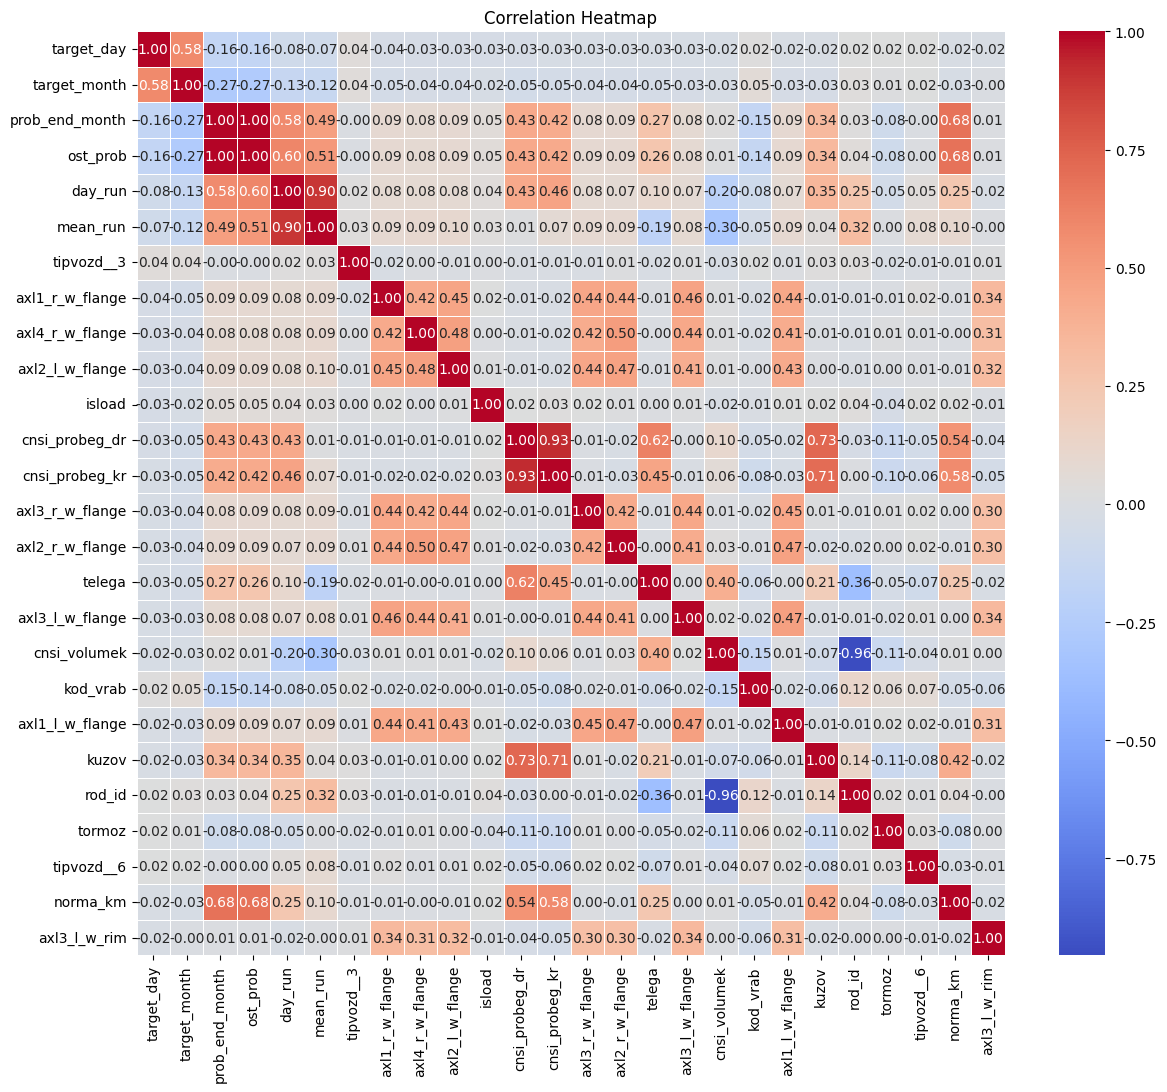

In [ ]:
plt.figure(figsize=(14, 12))
sns.heatmap(df_train_.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

#Обучение модели

In [ ]:
my_random_state = 1234

In [ ]:
y_day= df_train_['target_day']
y_month = df_train_['target_month']
x = df_train_.drop(['target_month', 'target_day'], axis=1)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_day, test_size=0.2, random_state = my_random_state)

In [ ]:
KNN_day = KNeighborsClassifier(n_neighbors=3)
KNN_day.fit(x, y_day)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = KNN_day.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9891752577319588


In [ ]:
joblib.dump(KNN_day, '/content/drive/MyDrive/DataWagon/KNN_day.sav')

['/content/drive/MyDrive/DataWagon/KNN_day.sav']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y_month, test_size=0.2, random_state = my_random_state)

In [ ]:
KNN_month = KNeighborsClassifier(n_neighbors=3)
KNN_month.fit(x, y_month)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
y_pred = KNN_month.predict(x_test)
print(accuracy_score(y_test, y_pred))

0.9690721649484536


In [ ]:
joblib.dump(KNN_month, '/content/drive/MyDrive/DataWagon/KNN_month.sav')

['/content/drive/MyDrive/DataWagon/KNN_month.sav']

#Загрузка и обработка данных для предсказания

In [ ]:
path_pred = '/content/drive/MyDrive/DataWagon/train_2/test'

In [ ]:
# список вагонов с остаточным пробегом на момент прогноза
wag_prob_pred = pd.read_parquet(path_pred + '/wagons_probeg_ownersip.parquet').convert_dtypes()
# данные по дислокации
dislok_pred = pd.read_parquet(path_pred + '/dislok_wagons.parquet').convert_dtypes()
# параметры вагона
wag_param_pred = pd.read_parquet(path_pred + '/wag_params.parquet').convert_dtypes()
# данные по текущим ремонтам
pr_rem_pred = pd.read_parquet(path_pred + '/pr_rems.parquet').convert_dtypes()
# текущие ремонты вагонов
tr_rem_pred = pd.read_parquet(path_pred + '/tr_rems.parquet').convert_dtypes()
# данные по КТИ
kti_izm_pred = pd.read_parquet(path_pred + '/kti_izm.parquet').convert_dtypes()
# справочник грузов
freight_info_pred = pd.read_parquet(path_pred + '/freight_info.parquet').convert_dtypes()
# справочник станций
stations_pred = pd.read_parquet(path_pred + '/stations.parquet').convert_dtypes()
# таргет по прогноза выбытия вагонов в ПР на месяц и на 10 дней
pred = pd.read_csv('/content/drive/MyDrive/DataWagon/train/target/y_predict.csv').convert_dtypes()

In [ ]:
dislok_pred = dislok_pred[dislok_pred['plan_date']!='2023-03-01T00:00:00.000000000']
wag_prob_pred = wag_prob_pred[(wag_prob_pred.repdate == pd.to_datetime('2023-02-28')) | (wag_prob_pred.repdate == wag_prob_pred.repdate.min())]

# оценим среднесуточный пробег из данных по пробегу вагона, на тот случай, если данных по нормативу нет
wag_prob_ =wag_prob_pred.groupby('wagnum', as_index = False).agg({'repdate':['max', 'min'] , 'ost_prob': ['max','min']},)#.droplevel(1)
wag_prob_.columns = [head+'_' + name
                     if head!='wagnum'
                     else head
                     for head, name in wag_prob_.columns ]

wag_prob_['diff_days'] = wag_prob_.repdate_max - wag_prob_.repdate_min
wag_prob_['mean_run'] = (wag_prob_.ost_prob_max - wag_prob_.ost_prob_min )/ wag_prob_.diff_days.dt.days
wag_prob_pred = wag_prob_pred[wag_prob_pred.repdate == wag_prob_pred.repdate.max()][['repdate','wagnum','ost_prob', 'manage_type', 'rod_id', 'reestr_state', 'month']]
wag_prob_pred = wag_prob_pred.merge(wag_prob_[['wagnum','mean_run']])

wag_prob_pred = wag_prob_pred.drop_duplicates(subset='wagnum', keep='last')
dislok_pred = dislok_pred.drop_duplicates(subset='wagnum', keep='last')
wag_param_pred = wag_param_pred.drop_duplicates(subset='wagnum', keep='last')
pr_rem_pred = pr_rem_pred.drop_duplicates(subset='wagnum', keep='last')
kti_izm_pred = kti_izm_pred.drop_duplicates(subset='wagnum', keep='last')

wag_prob_pred['month'] = wag_prob_pred['repdate'].apply(lambda x: str(pd.to_datetime(x, format='%Y-%m-%d').year) + '-' + str(pd.to_datetime(x, format='%Y-%m-%d').month))
dislok_pred['month'] = dislok_pred['plan_date'].apply(lambda x: str(pd.to_datetime(x, format='%Y-%m-%d').year) + '-' + str(pd.to_datetime(x, format='%Y-%m-%d').month))

# посчитаем сколько текущих ремонтов было за прошедший период
tr_rem_pred = tr_rem_pred.groupby('wagnum', as_index= False).kod_vrab.count()

wag_prob_pred = wag_prob_pred[wag_prob_pred.month==(str(pd.to_datetime(pred_data, format='%Y-%m-%d').year)+'-'+str(pd.to_datetime(pred_data, format='%Y-%m-%d').month))][['wagnum', 'ost_prob','rod_id','mean_run']]
dislok_pred = dislok_pred[dislok_pred.month==(str(pd.to_datetime(pred_data, format='%Y-%m-%d').year)+'-'+str(pd.to_datetime(pred_data, format='%Y-%m-%d').month))][['wagnum', 'date_kap', 'date_dep', 'date_pl_rem', 'ost_prob', 'isload', 'distance']]
wag_param_pred = wag_param_pred[['wagnum', 'gruz', 'cnsi_gruz_capacity', 'cnsi_volumek', 'tara', 'date_build', 'srok_sl', 'zavod_build', 'date_iskl', 'cnsi_probeg_dr', 'cnsi_probeg_kr', 'kuzov', 'telega', 'tormoz', 'tipvozd', 'tippogl', 'norma_km']]
pr_rem_pred = pr_rem_pred[['wagnum', 'road_id_send', 'road_id_rem','st_id_send', 'st_id_rem', 'distance']]
kti_izm_pred = kti_izm_pred[['wagnum', 'mileage_all', 'axl1_l_w_flange', 'axl1_r_w_flange', 'axl2_l_w_flange', 'axl2_r_w_flange', 'axl3_l_w_flange','axl3_r_w_flange', 'axl4_l_w_flange','axl4_r_w_flange', 'axl1_l_w_rim', 'axl1_r_w_rim', 'axl2_l_w_rim','axl2_r_w_rim',
                        'axl3_l_w_rim', 'axl3_r_w_rim', 'axl4_l_w_rim','axl4_r_w_rim']]
tr_term_pred = tr_rem_pred

df_pred = pred[['wagnum']].merge(wag_prob_pred, on ='wagnum', how = 'left')\
             .merge(dislok_pred, how = 'left')\
             .merge(wag_param_pred, how = 'left')\
             .merge(pr_rem_pred, how = 'left')\
             .merge(tr_term_pred, how = 'left')\
             .merge(kti_izm_pred, how = 'left')

df_pred[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run']] = df_pred[['cnsi_probeg_dr','cnsi_probeg_kr','mean_run']].fillna(0)
df_pred['day_run'] = df_pred.apply(lambda x : [ val  for val in [x.cnsi_probeg_kr, x.cnsi_probeg_dr, x.mean_run] if val != 0], axis = 1 )
df_pred['day_run']= df_pred.apply(lambda x : np.mean(x.day_run) if len(x.day_run)> 0 else 0, axis = 1 )

df_pred['current_date'] = pred_data

df_pred['date_diff_srk_sl'] = df_pred['srok_sl']- df_pred['current_date']

df_pred['date_diff_pl_rem'] = df_pred['date_pl_rem']- df_pred['current_date']

df_pred['prob_end_month'] = df_pred['ost_prob'] - df_pred['day_run']* 30

df_pred_ = df_pred.copy()

df_pred_.drop(['date_kap', 'date_dep', 'date_pl_rem', 'date_iskl', 'road_id_send', 'road_id_rem', 'st_id_send', 'st_id_rem', 'date_build', 'srok_sl', 'current_date', 'date_diff_srk_sl', 'date_diff_pl_rem'], axis=1, inplace=True)

df_pred_ = df_pred_.fillna(0)

mileage_mean = df_pred_[df_pred_['mileage_all'] != 0]['mileage_all'].mean()
df_pred_['mileage_all'] = df_pred_['mileage_all'].apply(lambda x: mileage_mean if x == 0 else x)

axl1_l_w_flange_mean = df_pred_[df_pred_['axl1_l_w_flange'] != 0]['axl1_l_w_flange'].mean()
df_pred_['axl1_l_w_flange'] = df_pred_['axl1_l_w_flange'].apply(lambda x: axl1_l_w_flange_mean if x == 0 else x)

axl1_r_w_flange_mean = df_pred_[df_pred_['axl1_r_w_flange'] != 0]['axl1_r_w_flange'].mean()
df_pred_['axl1_r_w_flange'] = df_pred_['axl1_r_w_flange'].apply(lambda x: axl1_r_w_flange_mean if x == 0 else x)

axl2_l_w_flange_mean = df_pred_[df_pred_['axl2_l_w_flange'] != 0]['axl2_l_w_flange'].mean()
df_pred_['axl2_l_w_flange'] = df_pred_['axl2_l_w_flange'].apply(lambda x: axl2_l_w_flange_mean if x == 0 else x)

axl2_r_w_flange_mean = df_pred_[df_pred_['axl2_r_w_flange'] != 0]['axl2_r_w_flange'].mean()
df_pred_['axl2_r_w_flange'] = df_pred_['axl2_r_w_flange'].apply(lambda x: axl2_r_w_flange_mean if x == 0 else x)

axl3_l_w_flange_mean = df_pred_[df_pred_['axl3_l_w_flange'] != 0]['axl3_l_w_flange'].mean()
df_pred_['axl3_l_w_flange'] = df_pred_['axl3_l_w_flange'].apply(lambda x: axl3_l_w_flange_mean if x == 0 else x)

axl3_r_w_flange_mean = df_pred_[df_pred_['axl3_r_w_flange'] != 0]['axl3_r_w_flange'].mean()
df_pred_['axl3_r_w_flange'] = df_pred_['axl3_r_w_flange'].apply(lambda x: axl3_r_w_flange_mean if x == 0 else x)

axl4_l_w_flange_mean = df_pred_[df_pred_['axl4_l_w_flange'] != 0]['axl4_l_w_flange'].mean()
df_pred_['axl4_l_w_flange'] = df_pred_['axl4_l_w_flange'].apply(lambda x: axl4_l_w_flange_mean if x == 0 else x)

axl4_r_w_flange_mean = df_pred_[df_pred_['axl4_r_w_flange'] != 0]['axl4_r_w_flange'].mean()
df_pred_['axl4_r_w_flange'] = df_pred_['axl4_r_w_flange'].apply(lambda x: axl4_r_w_flange_mean if x == 0 else x)

axl1_l_w_rim_mean = df_pred_[df_pred_['axl1_l_w_rim'] != 0]['axl1_l_w_rim'].mean()
df_pred_['axl1_l_w_rim'] = df_pred_['axl1_l_w_rim'].apply(lambda x: axl1_l_w_rim_mean if x == 0 else x)

axl1_r_w_rim_mean = df_pred_[df_pred_['axl1_r_w_rim'] != 0]['axl1_r_w_rim'].mean()
df_pred_['axl1_r_w_rim'] = df_pred_['axl1_r_w_rim'].apply(lambda x: axl1_r_w_rim_mean if x == 0 else x)

axl2_l_w_rim_mean = df_pred_[df_pred_['axl2_l_w_rim'] != 0]['axl2_l_w_rim'].mean()
df_pred_['axl1_l_w_rim'] = df_pred_['axl2_l_w_rim'].apply(lambda x: axl2_l_w_rim_mean if x == 0 else x)

axl2_r_w_rim_mean = df_pred_[df_pred_['axl2_r_w_rim'] != 0]['axl2_r_w_rim'].mean()
df_pred_['axl2_r_w_rim'] = df_pred_['axl2_r_w_rim'].apply(lambda x: axl2_r_w_rim_mean if x == 0 else x)

axl3_l_w_rim_mean = df_pred_[df_pred_['axl3_l_w_rim'] != 0]['axl3_l_w_rim'].mean()
df_pred_['axl3_l_w_rim'] = df_pred_['axl3_l_w_rim'].apply(lambda x: axl3_l_w_rim_mean if x == 0 else x)

axl3_r_w_rim_mean = df_pred_[df_pred_['axl3_r_w_rim'] != 0]['axl3_r_w_rim'].mean()
df_pred_['axl3_r_w_rim'] = df_pred_['axl3_r_w_rim'].apply(lambda x: axl3_r_w_rim_mean if x == 0 else x)

axl4_l_w_rim_mean = df_pred_[df_pred_['axl4_l_w_rim'] != 0]['axl4_l_w_rim'].mean()
df_pred_['axl4_l_w_rim'] = df_pred_['axl4_l_w_rim'].apply(lambda x: axl4_l_w_rim_mean if x == 0 else x)

axl4_r_w_rim_mean = df_pred_[df_pred_['axl4_r_w_rim'] != 0]['axl4_r_w_rim'].mean()
df_pred_['axl4_r_w_rim'] = df_pred_['axl4_r_w_rim'].apply(lambda x: axl4_r_w_rim_mean if x == 0 else x)

df_pred_['mileage_all'] = df_pred_['mileage_all'].apply(lambda x: int(str(x).replace('.', '')))

df_pred_ = pd.concat([df_pred_, pd.get_dummies(df_pred_['tipvozd'], prefix='tipvozd_')], axis=1)

df_pred_.drop('tipvozd', axis=1, inplace=True)

In [ ]:
df_pred_.describe()

,wagnum,ost_prob,rod_id,mean_run,isload,distance,gruz,cnsi_gruz_capacity,cnsi_volumek,tara,...,tipvozd__16,tipvozd__19,tipvozd__2,tipvozd__21,tipvozd__3,tipvozd__4,tipvozd__6,tipvozd__7,tipvozd__8,tipvozd__9
count,33707.0,33707.0,33707.0,33707.0,33707.0,33707.0,33707.0,33707.0,33707.0,33707.0,...,33707.000000,33707.000000,33707.000000,33707.00000,33707.000000,33707.000000,33707.000000,33707.000000,33707.000000,33707.000000
mean,17062.180437,95979.374581,0.616548,382.679623,0.410953,550.027798,688.77696,688.77696,110.915507,249.827395,...,0.034058,0.040407,0.000059,0.00089,0.002017,0.088201,0.068265,0.505681,0.013706,0.000030
std,9805.705493,68584.911645,0.486234,1069.340748,0.492014,1268.722311,15.621063,15.621063,30.995392,13.425157,...,0.181381,0.196915,0.007703,0.02982,0.044871,0.283592,0.252203,0.499975,0.116271,0.005447
min,0.0,-5932.0,0.0,0.0,0.0,-1.0,660.0,660.0,73.0,217.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8663.5,45432.0,0.0,71.62963,0.0,-1.0,672.0,672.0,88.0,240.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,17115.0,95375.0,1.0,149.666667,0.0,-1.0,695.0,695.0,88.0,243.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
75%,25546.5,139023.0,1.0,260.240741,1.0,304.5,695.0,695.0,138.0,265.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,33976.0,500000.0,1.0,12922.185185,1.0,10361.0,750.0,750.0,174.0,273.0,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
pred[['target_month', 'target_day']] = 0

In [ ]:
columns

Index(['target_day', 'target_month', 'prob_end_month', 'ost_prob', 'day_run',
       'mean_run', 'tipvozd__3', 'axl1_r_w_flange', 'axl4_r_w_flange',
       'axl2_l_w_flange', 'isload', 'cnsi_probeg_dr', 'cnsi_probeg_kr',
       'axl3_r_w_flange', 'axl2_r_w_flange', 'telega', 'axl3_l_w_flange',
       'cnsi_volumek', 'kod_vrab', 'axl1_l_w_flange', 'kuzov', 'rod_id',
       'tormoz', 'tipvozd__6', 'norma_km', 'axl3_l_w_rim'],
      dtype='object')

In [ ]:
columns = [i for i in columns]

In [ ]:
columns.append('wagnum')
columns.remove('target_day')
columns.remove('target_month')

In [ ]:
len(columns)

25

In [ ]:
df_pred_ = df_pred_[columns]

#Проведение предсказания модели

In [ ]:
KNN_day = joblib.load('/content/drive/MyDrive/DataWagon/KNN_day.sav')
KNN_month = joblib.load('/content/drive/MyDrive/DataWagon/KNN_month.sav')

In [ ]:
for i in pred['wagnum'].values:
  #если в прошлом месяце был ремонт, то в текущем его не будет
  if train[train['wagnum']== i]['target_month'].values[0] == 1:
    pred.loc[pred['wagnum']==i, 'target_month'] = 0
    pred.loc[pred['wagnum']==i, 'target_day'] = 0
  else:
    x = df_pred_[df_pred_['wagnum'] == i].drop('wagnum', axis=1)
    pred_day = KNN_day.predict(x)
    if pred_day == 1:
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_day[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
    else:
      pred_month = KNN_month.predict(x)
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_month[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
pred

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [ ]:
pred.to_csv('/content/drive/MyDrive/DataWagon/y_pred_submit.csv')

In [ ]:
knn_results = calc_f1_score('/content/drive/MyDrive/DataWagon/y_pred_submit.csv', '/content/drive/MyDrive/DataWagon/y_predict.csv')
knn_results = {'all': f'{knn_results[0]*100:.2f}', 'month': f'{knn_results[1]*100:.2f}', 'day': f'{knn_results[2]*100:.2f}'}

In [ ]:
knn_results

{'all': '40.05', 'month': '50.49', 'day': '29.61'}

In [ ]:
knn = pd.DataFrame({'':knn_results.keys(), '%':knn_results.values()})
knn.to_csv('/content/drive/MyDrive/DataWagon/knn_results.csv')

#CatBoost

In [ ]:
!pip install CatBoost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 10.0 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
y_day= df_train_['target_day']
y_month = df_train_['target_month']
x = df_train_.drop(['target_month', 'target_day'], axis=1)

In [ ]:
CB_day = CatBoostClassifier()
CB_day.fit(x, y_day)

Learning rate set to 0.027177
0:	learn: 0.6399672	total: 55.5ms	remaining: 55.5s
1:	learn: 0.5719457	total: 64.2ms	remaining: 32s
2:	learn: 0.5294244	total: 72ms	remaining: 23.9s
3:	learn: 0.4878786	total: 82.1ms	remaining: 20.4s
4:	learn: 0.4453441	total: 94.7ms	remaining: 18.9s
5:	learn: 0.4046754	total: 105ms	remaining: 17.4s
6:	learn: 0.3726030	total: 121ms	remaining: 17.1s
7:	learn: 0.3369100	total: 131ms	remaining: 16.3s
8:	learn: 0.3152311	total: 139ms	remaining: 15.3s
9:	learn: 0.2948358	total: 150ms	remaining: 14.8s
10:	learn: 0.2726761	total: 161ms	remaining: 14.5s
11:	learn: 0.2563436	total: 169ms	remaining: 13.9s
12:	learn: 0.2378744	total: 179ms	remaining: 13.6s
13:	learn: 0.2179611	total: 190ms	remaining: 13.4s
14:	learn: 0.1968099	total: 204ms	remaining: 13.4s
15:	learn: 0.1838207	total: 215ms	remaining: 13.2s
16:	learn: 0.1715805	total: 223ms	remaining: 12.9s
17:	learn: 0.1619511	total: 239ms	remaining: 13s
18:	learn: 0.1526953	total: 249ms	remaining: 12.8s
19:	learn: 0

In [ ]:
joblib.dump(CB_day, '/content/drive/MyDrive/DataWagon/CB_day.sav')

['/content/drive/MyDrive/DataWagon/CB_day.sav']

In [ ]:
CB_month = CatBoostClassifier()
CB_month.fit(x, y_month)

Learning rate set to 0.027177
0:	learn: 0.6218731	total: 4.77ms	remaining: 4.77s
1:	learn: 0.5647087	total: 9.18ms	remaining: 4.58s
2:	learn: 0.5278658	total: 14.3ms	remaining: 4.75s
3:	learn: 0.4866875	total: 18.9ms	remaining: 4.71s
4:	learn: 0.4444855	total: 23.6ms	remaining: 4.69s
5:	learn: 0.4128548	total: 28.3ms	remaining: 4.68s
6:	learn: 0.3860348	total: 32.8ms	remaining: 4.66s
7:	learn: 0.3602975	total: 37.4ms	remaining: 4.63s
8:	learn: 0.3417161	total: 41.8ms	remaining: 4.61s
9:	learn: 0.3216884	total: 46.2ms	remaining: 4.58s
10:	learn: 0.3078276	total: 50.7ms	remaining: 4.56s
11:	learn: 0.2915949	total: 55ms	remaining: 4.53s
12:	learn: 0.2739467	total: 59.6ms	remaining: 4.53s
13:	learn: 0.2636293	total: 63.9ms	remaining: 4.5s
14:	learn: 0.2513288	total: 68.3ms	remaining: 4.48s
15:	learn: 0.2412472	total: 72.8ms	remaining: 4.47s
16:	learn: 0.2297588	total: 77.3ms	remaining: 4.47s
17:	learn: 0.2228174	total: 81.8ms	remaining: 4.46s
18:	learn: 0.2098952	total: 86.5ms	remaining: 4

In [ ]:
joblib.dump(CB_month, '/content/drive/MyDrive/DataWagon/CB_month.sav')

['/content/drive/MyDrive/DataWagon/CB_month.sav']

In [ ]:
CB_day = joblib.load('/content/drive/MyDrive/DataWagon/CB_day.sav')
CB_month = joblib.load('/content/drive/MyDrive/DataWagon/CB_month.sav')

In [ ]:
for i in pred['wagnum'].values:
  #если в прошлом месяце был ремонт, то в текущем его не будет
  if train[train['wagnum']== i]['target_month'].values[0] == 1:
    pred.loc[pred['wagnum']==i, 'target_month'] = 0
    pred.loc[pred['wagnum']==i, 'target_day'] = 0
  else:
    x = df_pred_[df_pred_['wagnum'] == i].drop('wagnum', axis=1)
    pred_day = CB_day.predict(x)
    if pred_day == 1:
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_day[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
    else:
      pred_month = CB_month.predict(x)
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_month[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
pred

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [ ]:
pred.to_csv('/content/drive/MyDrive/DataWagon/y_pred_cb.csv')

In [ ]:
cb_results = calc_f1_score('/content/drive/MyDrive/DataWagon/y_pred_cb.csv', '/content/drive/MyDrive/DataWagon/y_predict.csv')
cb_results = {'all': f'{cb_results[0]*100:.2f}', 'month': f'{cb_results[1]*100:.2f}', 'day': f'{cb_results[2]*100:.2f}'}
cb_results

{'all': '39.14', 'month': '46.66', 'day': '31.62'}

In [ ]:
cb = pd.DataFrame({'':cb_results.keys(), '%':cb_results.values()})
cb.to_csv('/content/drive/MyDrive/DataWagon/cb_results.csv')

#LogisticRegression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
y_day= df_train_['target_day']
y_month = df_train_['target_month']
x = df_train_.drop(['target_month', 'target_day'], axis=1)

In [ ]:
LR_day = LogisticRegression()
LR_day.fit(x, y_day)

LogisticRegression()

In [ ]:
joblib.dump(LR_day, '/content/drive/MyDrive/DataWagon/LR_day.sav')

['/content/drive/MyDrive/DataWagon/LR_day.sav']

In [ ]:
LR_month = LogisticRegression()
LR_month.fit(x, y_month)

LogisticRegression()

In [ ]:
joblib.dump(LR_month, '/content/drive/MyDrive/DataWagon/LR_month.sav')

['/content/drive/MyDrive/DataWagon/LR_month.sav']

In [ ]:
LR_day = joblib.load('/content/drive/MyDrive/DataWagon/LR_day.sav')
LR_month = joblib.load('/content/drive/MyDrive/DataWagon/LR_month.sav')

In [ ]:
for i in pred['wagnum'].values:
  #если в прошлом месяце был ремонт, то в текущем его не будет
  if train[train['wagnum']== i]['target_month'].values[0] == 1:
    pred.loc[pred['wagnum']==i, 'target_month'] = 0
    pred.loc[pred['wagnum']==i, 'target_day'] = 0
  else:
    x = df_pred_[df_pred_['wagnum'] == i].drop('wagnum', axis=1)
    pred_day = LR_day.predict(x)
    if pred_day == 1:
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_day[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
    else:
      pred_month = LR_month.predict(x)
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_month[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
pred

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [ ]:
pred.to_csv('/content/drive/MyDrive/DataWagon/y_pred_lr.csv')

In [ ]:
lr_results = calc_f1_score('/content/drive/MyDrive/DataWagon/y_pred_lr.csv', '/content/drive/MyDrive/DataWagon/y_predict.csv')
lr_results = {'all': f'{lr_results[0]*100:.2f}', 'month': f'{lr_results[1]*100:.2f}', 'day': f'{lr_results[2]*100:.2f}'}
lr_results

{'all': '11.01', 'month': '21.67', 'day': '0.34'}

In [ ]:
lr = pd.DataFrame({'':lr_results.keys(), '%':lr_results.values()})
lr.to_csv('/content/drive/MyDrive/DataWagon/lr_results.csv')

#GradientBoostingClassifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
y_day= df_train_['target_day']
y_month = df_train_['target_month']
x = df_train_.drop(['target_month', 'target_day'], axis=1)

In [ ]:
GBC_day = GradientBoostingClassifier()
GBC_day.fit(x, y_day)

GradientBoostingClassifier()

In [ ]:
joblib.dump(GBC_day, '/content/drive/MyDrive/DataWagon/GBC_day.sav')

['/content/drive/MyDrive/DataWagon/GBC_day.sav']

In [ ]:
GBC_month = GradientBoostingClassifier()
GBC_month.fit(x, y_month)

GradientBoostingClassifier()

In [ ]:
joblib.dump(GBC_month, '/content/drive/MyDrive/DataWagon/GBC_month.sav')

['/content/drive/MyDrive/DataWagon/GBC_month.sav']

In [ ]:
GBC_day = joblib.load('/content/drive/MyDrive/DataWagon/GBC_day.sav')
GBC_month = joblib.load('/content/drive/MyDrive/DataWagon/GBC_month.sav')

In [ ]:
for i in pred['wagnum'].values:
  #если в прошлом месяце был ремонт, то в текущем его не будет
  if train[train['wagnum']== i]['target_month'].values[0] == 1:
    pred.loc[pred['wagnum']==i, 'target_month'] = 0
    pred.loc[pred['wagnum']==i, 'target_day'] = 0
  else:
    x = df_pred_[df_pred_['wagnum'] == i].drop('wagnum', axis=1)
    pred_day = GBC_day.predict(x)
    if pred_day == 1:
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_day[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
    else:
      pred_month = GBC_month.predict(x)
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_month[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
pred

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [ ]:
pred.to_csv('/content/drive/MyDrive/DataWagon/y_pred_gbc.csv')

In [ ]:
gbc_results = calc_f1_score('/content/drive/MyDrive/DataWagon/y_pred_gbc.csv', '/content/drive/MyDrive/DataWagon/y_predict.csv')
gbc_results = {'all': f'{gbc_results[0]*100:.2f}', 'month': f'{gbc_results[1]*100:.2f}', 'day': f'{gbc_results[2]*100:.2f}'}
gbc_results

{'all': '39.62', 'month': '50.02', 'day': '29.22'}

In [ ]:
gbc = pd.DataFrame({'':gbc_results.keys(), '%':gbc_results.values()})
gbc.to_csv('/content/drive/MyDrive/DataWagon/gb_results.csv')

#Total

In [ ]:
CB_day = joblib.load('/content/drive/MyDrive/DataWagon/CB_day.sav')
KNN_month = joblib.load('/content/drive/MyDrive/DataWagon/KNN_month.sav')

In [ ]:
for i in pred['wagnum'].values:
  #если в прошлом месяце был ремонт, то в текущем его не будет
  if train[train['wagnum']== i]['target_month'].values[0] == 1:
    pred.loc[pred['wagnum']==i, 'target_month'] = 0
    pred.loc[pred['wagnum']==i, 'target_day'] = 0
  else:
    x = df_pred_[df_pred_['wagnum'] == i].drop('wagnum', axis=1)
    pred_day = CB_day.predict(x)
    if pred_day == 1:
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_day[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
    else:
      pred_month = KNN_month.predict(x)
      pred.loc[pred['wagnum']==i, 'target_month'] = int(pred_month[0])
      pred.loc[pred['wagnum']==i, 'target_day'] = int(pred_day[0])
pred

,wagnum,month,target_month,target_day
0,33361,2023-03-01,0,0
1,33364,2023-03-01,0,0
2,33366,2023-03-01,0,0
3,33358,2023-03-01,0,0
4,33349,2023-03-01,0,0
...,...,...,...,...
33702,17621,2023-03-01,0,0
33703,25045,2023-03-01,0,0
33704,27156,2023-03-01,0,0
33705,21361,2023-03-01,0,0


In [ ]:
pred.to_csv('/content/drive/MyDrive/DataWagon/y_pred_ttl.csv')

In [ ]:
ttl_results = calc_f1_score('/content/drive/MyDrive/DataWagon/y_pred_ttl.csv', '/content/drive/MyDrive/DataWagon/y_predict.csv')
ttl_results = {'all': f'{ttl_results[0]*100:.2f}', 'month': f'{ttl_results[1]*100:.2f}', 'day': f'{ttl_results[2]*100:.2f}'}
ttl_results

{'all': '42.02', 'month': '52.41', 'day': '31.62'}

In [ ]:
ttl = pd.DataFrame({'':ttl_results.keys(), '%':ttl_results.values()})
ttl.to_csv('/content/drive/MyDrive/DataWagon/ttl_results.csv')

#SQL


In [ ]:
import sqlite3
from sqlite3 import Error

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

In [ ]:
connection = create_connection("/content/drive/MyDrive/DataWagon/sm_app.sqlite")

Connection to SQLite DB successful


In [ ]:
def execute_query(connection, query):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        print("Query executed successfully")
    except Error as e:
        print(f"The error '{e}' occurred")

In [ ]:
knn_results_table = """
CREATE TABLE IF NOT EXISTS knn_results(
  total FLOAT,
  pred_month FLOAT,
  pred_day FLOAT
);
"""

In [ ]:
execute_query(connection, knn_results_table)

Query executed successfully


In [ ]:
cb_results_table = """
CREATE TABLE IF NOT EXISTS cb_results(
  total FLOAT,
  pred_month FLOAT,
  pred_day FLOAT
);
"""

In [ ]:
execute_query(connection, cb_results_table)

Query executed successfully


In [ ]:
gb_results_table = """
CREATE TABLE IF NOT EXISTS gb_results(
  total FLOAT,
  pred_month FLOAT,
  pred_day FLOAT
);
"""

In [ ]:
execute_query(connection, gb_results_table)

Query executed successfully


In [ ]:
lr_results_table = """
CREATE TABLE IF NOT EXISTS lr_results(
  total FLOAT,
  pred_month FLOAT,
  pred_day FLOAT
);
"""

In [ ]:
execute_query(connection, lr_results_table)

Query executed successfully


In [ ]:
ttl_results_table = """
CREATE TABLE IF NOT EXISTS ttl_results(
  total FLOAT,
  pred_month FLOAT,
  pred_day FLOAT
);
"""

In [ ]:
execute_query(connection, ttl_results_table)

Query executed successfully


In [ ]:
pred_table = """
CREATE TABLE IF NOT EXISTS pred_table(
  wagnum INTEGER,
  month TEXT,
  target_month INTEGER,
  target_day INTEGER
);
"""

In [ ]:
execute_query(connection, pred_table)

Query executed successfully


In [ ]:
def csv_to_sql(connection, path):
  table = pd.read_csv(path)
  table.drop('Unnamed: 0', axis=1, inplace=True)
  table.index = table['Unnamed: 1'].values
  table.drop('Unnamed: 1', axis=1, inplace=True)
  table = table.transpose()
  cursor = connection.cursor()
  try:
    for row in table.itertuples():
      cursor.execute(f'''INSERT INTO {str(path.split('/')[5].replace('.csv', ''))}(total, pred_month, pred_day) VALUES ({row.all},{row.month},{ row.day});''')
    connection.commit()
    print("Query executed successfully")
  except Error as e:
    print(f"The error '{e}' occurred")

In [ ]:
path = '/content/drive/MyDrive/DataWagon/cb_results.csv'
csv_to_sql(connection, path)

Query executed successfully


In [ ]:
path = '/content/drive/MyDrive/DataWagon/gb_results.csv'
csv_to_sql(connection, path)

Query executed successfully


In [ ]:
path = '/content/drive/MyDrive/DataWagon/knn_results.csv'
csv_to_sql(connection, path)

Query executed successfully


In [ ]:
path = '/content/drive/MyDrive/DataWagon/lr_results.csv'
csv_to_sql(connection, path)

Query executed successfully


In [ ]:
path = '/content/drive/MyDrive/DataWagon/ttl_results.csv'
csv_to_sql(connection, path)

Query executed successfully


In [ ]:
path = '/content/drive/MyDrive/DataWagon/y_pred_ttl.csv'
table = pd.read_csv(path)
cursor = connection.cursor()
try:
  for row in table.itertuples():
    cursor.execute(f'''INSERT INTO pred_table(wagnum, month, target_month, target_day) VALUES ({row.wagnum},{row.month},{row.target_month}, {row.target_day});''')
  connection.commit()
  print("Query executed successfully")
except Error as e:
  print(f"The error '{e}' occurred")

Query executed successfully


In [ ]:
def execute_read_query(connection, query):
    cursor = connection.cursor()
    result = None
    try:
        cursor.execute(query)
        result = cursor.fetchall()
        return result
    except Error as e:
        print(f"The error '{e}' occurred")

In [ ]:
select_users = "SELECT * from knn_results"
users = execute_read_query(connection, select_users)

for user in users:
    print(user)

(40.05, 50.49, 29.61)
